In [0]:
import warnings
warnings.filterwarnings('ignore')

**Mounting Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**Loading required libraries**

In [5]:
import h5py
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils

Using TensorFlow backend.


**Reading the datafile**

In [0]:
# Open the file as readonly
h5f = h5py.File('/content/drive/My Drive/DLCP/SVHN_single_grey1.h5', 'r')

## Splitting Dataset into Train & Test

#### Also Normalize the data by dividing with 255.0 (Dividing by 255.0 will ensure that the data remains a floating number instead of returning integer values like 1 & 0)

In [7]:
# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]


# Close this file
h5f.close()

X_train = X_train.reshape(X_train.shape[0], 1024)
X_test = X_test.reshape(X_test.shape[0], 1024)

# # normalize inputs from 0-255 to 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

print('Training set', X_train.shape, y_train.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (42000, 1024) (42000,)
Test set (18000, 1024) (18000,)


In [9]:
print(X_train.shape)
print(y_train.shape)

(42000, 1024)
(42000,)


In [10]:
print(X_test.shape)
print(y_test.shape)

(18000, 1024)
(18000,)


**Define the Fully Connected Layer**

In [0]:
# The fully connected linear layer does matrix-vector multiplication
# of inputs and then add the bias

class Linear():
    
    # this is the constructor that keeps some state
    # We have parameters Weights, W
    # We have biases, B
    # We have the input size & output size
    # Size of the images is 28 X 28
    # So we have 784 as the input size
    # We will have some output size. In our case
    # we have 10 classes so our output size will be 10

    def __init__(self, in_size, out_size):

        # We create a matrix of size input_size X output_size
        # i.e. our matrix is of 783 X 10
        # And we initialize the weights with 0.01
        self.W = np.random.randn(in_size, out_size) * 0.01
        
        # We set the bias to Zeroes
        # The size of the bias will have the size of the output
        # So it will have the size 1 X 10
        self.b = np.zeros((1, out_size))
        
        # Its a good practice to have the list of params
        # for easier iterations
        self.params = [self.W, self.b]
        
        # We need 3 more variables which we will use in the backward functions
        # These are the gradients w.r.t weights, bias & the inputs
        self.gradW = None
        self.gradB = None
        self.gradInput = None        

    # Here you have the input X being passed to the forward function
    def forward(self, X):
        self.X = X

        # Vector Matrix multiplication is performed
        # Matrix W of weights multipled with the input values
        # Bias is then added
        # Size of the bias is same as output size
        self.output = np.dot(X, self.W) + self.b
        return self.output

    # When we want to do the backward
    # we need the graident coming in from next layer which
    # we call here it as nextgrad
    def backward(self, nextgrad):
        # Gradients for the weights will be gradients coming in 
        # from the next layer multiplied by the inputs
        # This is the Jacobian turns out to be X in case of gradW
        # This is the Jacobian turns out to be W in case of gradInput
        self.gradW = np.dot(self.X.T, nextgrad)

        # We similar compute the gradients for the bias
        self.gradB = np.sum(nextgrad, axis=0)

        # This are the gradients we will pass to the previous layer
        # This is same as multiplication of transpose W with the gradients
        # coming in from the next layer        
        self.gradInput = np.dot(nextgrad, self.W.T)

        # We return the input gradient first and then the
        # gradients w.r.t. the parameters W & the bias
        return self.gradInput, [self.gradW, self.gradB]

## **Rectified Linear Unit Activation Layer (RELU)**

### RELU is an activation function. The ReLU function returns zero when the argument to the function is less than zero and the function is equal to the argument when the argument is above or equal to zero.

### It ranges from [0 to Infinity)

### The function and its derivative both are monotonic. The issue is that all the negative values become zero immediately which decreases the ability of the model to fit or train from the data properly. That means any negative input given to the ReLU activation function turns the value into zero immediately. 

### That can make us use LeakyRELU. However, in this case we will go ahead using RELU.

In [0]:
# Define a class RELU for the Rectified Linear Activation Layer
# Note no gradW or gradB parameters because its an activation function
# and has no parameters
class ReLU():
    def __init__(self):
        # RELU has no parameters
        # However we will initialize to an empty list      
        self.params = []

        # We will have this gradInput variable to hold the
        # state which we will populate in the backward function
        self.gradInput = None

    def forward(self, X):
        # When we have an input, we want
        # anything less than zero to be zero i.e y becomes zero
        # and anything greater than zero then y becomes x      
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        # Copy the gradients coming in from next layer      
        self.gradInput = nextgrad.copy()
        
        # What ii does is whenever the output was positive, 
        # it lets the gradient from the next layer pass through
        # and whenever it was negative it blocks it and makes it equal to zero        
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []

##**Define Softmax Function**

### Softmax Function is a generalization of the logistic function. The softmax function is used in various multiclass classification methods, such as multinomial logistic regression, multiclass linear discriminant analysis, naive Bayes classifiers, and artificial neural networks.

In [0]:
def softmax(x):
    # For each omponent we simply exponentiate it
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    
    # Divide by the sum of all exponentials
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

## **Define the Cross Entropy Loss**

### The cross entropy between two probability distributions p and q over the same underlying set of events measures the average number of bits needed to identify an event drawn from the set.

### In other words, Cross Entropy is the number of bits we'll need if we encode symbols from  y  using the wrong tool  ŷ.

### Cross entropy is always larger than entropy; encoding symbols according to the wrong distribution  ŷ will always make us use more bits. The only exception is the trivial case where  y  and  ŷ   are equal, and in this case entropy and cross entropy are equal.

In [0]:
class CrossEntropy():
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y])
        loss = cross_entropy[0] / self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

### **Visualizing first ten images with their labels**

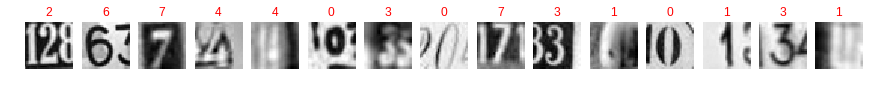

In [23]:
# Visualizing the 1st 10 images in our dataset
# along with the labels
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 1))
for i in range(15):
    plt.subplot(1, 15, i+1)
    plt.imshow(X_train[i].reshape(32,32), cmap="gray")
    plt.title(y_train[i], color='r')
    plt.axis("off")
plt.show()

### Define the container NN class that enables the forward prop and backward propagation of the entire network. Note, how this class enables us to add layers of different types and also correctly pass gradients using the chain rule. Add L2 Regularization.

In [0]:
# This class enables the forward prop & backward prop to the network
class NN():
  
  # This is the constructor and it takes Cross Entropy as the loss function
  # CrossEntropy() is the function that we have defined earlier
  def __init__(self, lossfunc=CrossEntropy(), mode='train'):
        
        # params[] list to have all all the parameters
        # If we have 2 layers, then we will have 4 of parameters
        # weights & biases of 1st and 2nd layer
        self.params = []
        
        # We assume all our layers are sequential layers
        self.layers = []
        
        # Out loss function is the Cross Entropy Loss Function
        self.loss_func = lossfunc
        
        # This list will contain the gradients w.r.t. the parameters
        # So we can use them to update the gradients during training
        self.grads = []
        
        self.mode = mode
        
        
  # add_layer adds layer of different types to the network  
  # the layer parameter to the add_layer passes the kind of layer we want
  # We have defined types of layers like Linear Layer, RELU Layer
  # This function will append the layers to the NN class
  # It will also take the parameters of the layers and put it into params[]
  def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

  # This function needs an input X and will give an output X
  # The individual forwards of each layer is called
  # So the layer.forward() takes X as an input, moves forward through
  # the whole layer and gives the output X
  # In this function all the layers are iterated through
  def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

  # 
  def backward(self, nextgrad):
    
        # We start with clearing the gradient parameters
        # Note: We do not update the weights in the backward()
        # This fucntion simply re-initializes the parameters to an 
        # empty list
        self.clear_grad_param()
        
        # When we want to do backprop, we want to start
        # with the last layer. So we use reversed()
        for layer in reversed(self.layers):
          
            # we call the layer.backward() for each layer
            # nextgrad are the graidents which we want to pass to the previous 
            # layer 
            # grad are the gradients we use to update the params
            # so we store grad to self.grads
            # the number of elements in self.grads = self.pramas
            nextgrad, grad = layer.backward(nextgrad)
            
            # The layer.backward will call RELU.backward depending on what
            # we have passed. Thr RELU.backward will be called with nextgrad
            
            self.grads.append(grad)
            # We keep doing the above for all layers backward
        return self.grads

  # This is the actual training step
  # takes the input X and the target y
  # then does the "forward"
  # calculates the "loss"
  # then does the "backward"
  def train_step(self, X, y):
    
        # calls the forward() to forward the whole thing
        # then we have the scores
        out = self.forward(X)
        
        # pass the scores to the cross entropy function
        # get the loss from cross entropy function
        loss = self.loss_func.forward(out,y)
        
        # calling the backward
        # to get the input gradients that need to be passed
        # to the 2nd layer
        # size of the next grad will be same as the last later i.e. 10 in our
        # case
        nextgrad = self.loss_func.backward(out,y)
        
        # Calls the entire backward of the network
        # so that we have the gradients populated
        grads = self.backward(nextgrad)
        return loss, grads
  
  # Once we have completely trained the network
  # we call the predict function to get the class
  # we return the argmax
  # Whichever class has max score 
  def predict(self, X):
        
        # gets the class from the forward()
        X = self.forward(X)
        p = softmax(X)
        return np.argmax(p, axis=1)
  
  # Here we do not do the argmax
  # Here we get to see the entire scores
  def predict_scores(self, X):
        X = self.forward(X)
        p = softmax(X)
        return p
  
  # This function simply clears the self.grads
  def clear_grad_param(self):
        self.grads = []

### Define the update function (SGD)

In [0]:
def update(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = (mu * v[i]) - (learning_rate * g[i])
            p[i] += v[i]

 ### Define a function which gives us the minibatches (both the datapoint and the corresponding label)


In [0]:
# get minibatches
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]

        minibatches.append((X_batch, y_batch))
    return minibatches

### The traning loop


In [0]:
def sgd(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9, X_val=None, y_val=None, Lambda=0, verb=True):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)
    
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)
            
        # iterate over mini batches
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)
        
        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = []
        y_val_pred = []
        y_train1 = []
        y_vall = []
        for ii in range(0, m_train, minibatch_size):
            X_tr = X_train[ii:ii + minibatch_size, : ]
            y_tr = y_train[ii:ii + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr))

        for ii in range(0, m_val, minibatch_size):
            X_va = X_val[ii:ii + minibatch_size, : ]
            y_va = y_val[ii:ii + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va))
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)
        
        ## weights
        w = np.array(net.params[0][0])
        
        ## adding regularization to cost
        mean_train_loss = (sum(loss_batch) / float(len(loss_batch)))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        if verb:
            if i%50==0:
                print("Epoch {3}/{4}: Loss = {0} | Training Accuracy = {1}".format(mean_train_loss, train_acc, val_acc, i, epoch))
    return net, val_acc

### Checking the accuracy of the model 

In [0]:
def check_accuracy(y_true, y_pred):
    count = 0
    for i,j in zip(y_true, y_pred):
        if int(i)==j:
            count +=1
    return float(count)/float(len(y_true))

In [21]:
X_train.shape

(42000, 1024)

### Invoking all that we have created until now

In [0]:
from random import shuffle


## input size
input_dim = X_train.shape[1]

def train_and_test_loop(iterations, lr, Lambda, verb=True):
    ## hyperparameters
    iterations = iterations
    learning_rate = lr
    hidden_nodes = 10
    output_nodes = 10

    ## define neural net
    nn = NN()
    nn.add_layer(Linear(input_dim, hidden_nodes))

    nn, val_acc = sgd(nn, X_train , y_train, minibatch_size=1000, epoch=iterations, learning_rate=learning_rate,\
                      X_val=X_test, y_val=y_test, Lambda=Lambda, verb=verb)
    return val_acc

### Double Check that the loss is reasonable : Disable the regularization


In [30]:
lr = 0.00001
Lambda = 0
train_and_test_loop(1, lr, Lambda)

Epoch 0/1: Loss = 0.0022953103716985518 | Training Accuracy = 0.10354761904761904


0.10516666666666667

### Now, lets crank up the Lambda(Regularization)and check what it does to our loss function.

In [24]:
lr = 0.00001
Lambda = 1e3
train_and_test_loop(1, lr, Lambda)

Epoch 0/1: Loss = 0.002290574556999201 | Training Accuracy = 0.10066666666666667


0.10283333333333333

### Now, lets overfit to a small subset of our dataset, in this case 20 images.

In [25]:
X_train_subset = X_train[0:20]
y_train_subset = y_train[0:20]
X_train = X_train_subset
y_train = y_train_subset
print(X_train.shape)
print(y_train.shape)

(20, 1024)
(20,)


### Tip: Make sure that you can overfit very small portion of the training data
So, set a small learning rate and turn regularization off

In the code below:
- Take the first 20 examples from MNIST
- turn off regularization(reg=0.0)
- use simple vanilla 'sgd'

In [26]:
lr = 0.0001
Lambda = 0
train_and_test_loop(10000, lr, Lambda)

Epoch 0/10000: Loss = 0.1153187839055569 | Training Accuracy = 0.15
Epoch 50/10000: Loss = 0.11029793766366283 | Training Accuracy = 0.2
Epoch 100/10000: Loss = 0.1063778994313391 | Training Accuracy = 0.2
Epoch 150/10000: Loss = 0.10328278684699332 | Training Accuracy = 0.2
Epoch 200/10000: Loss = 0.1007869880883187 | Training Accuracy = 0.2
Epoch 250/10000: Loss = 0.09871880450859835 | Training Accuracy = 0.15
Epoch 300/10000: Loss = 0.09695482732486 | Training Accuracy = 0.2
Epoch 350/10000: Loss = 0.09541031479573828 | Training Accuracy = 0.15
Epoch 400/10000: Loss = 0.0940290741148464 | Training Accuracy = 0.25
Epoch 450/10000: Loss = 0.09277467459989402 | Training Accuracy = 0.25
Epoch 500/10000: Loss = 0.09162363890865667 | Training Accuracy = 0.3
Epoch 550/10000: Loss = 0.09056057953577584 | Training Accuracy = 0.25
Epoch 600/10000: Loss = 0.08957494330387386 | Training Accuracy = 0.3
Epoch 650/10000: Loss = 0.0886589527660627 | Training Accuracy = 0.3
Epoch 700/10000: Loss = 0

0.1126111111111111

### Loading the original dataset again

In [31]:
# Open the file as readonly
h5f = h5py.File('/content/drive/My Drive/DLCP/SVHN_single_grey1.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]


# Close this file
h5f.close()

X_train = X_train.reshape(X_train.shape[0], 1024)
X_test = X_test.reshape(X_test.shape[0], 1024)

# # normalize inputs from 0-255 to 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

print('Training set', X_train.shape, y_train.shape)
print('Test set', X_test.shape, y_test.shape)

X_val = X_test
y_val = y_test



Training set (42000, 1024) (42000,)
Test set (18000, 1024) (18000,)


### Start with small regularization and find learning rate that makes the loss go down.

- we start with Lambda(small regularization) = 1e-7
- we start with a small learning rate = 1e-7

In [28]:
lr = 1e-7
Lambda = 1e-7
train_and_test_loop(500, lr, Lambda)

Epoch 0/500: Loss = 0.0023200377189507575 | Training Accuracy = 0.1040952380952381
Epoch 50/500: Loss = 0.0023191087808429075 | Training Accuracy = 0.1040952380952381
Epoch 100/500: Loss = 0.0023182381384005005 | Training Accuracy = 0.10423809523809524
Epoch 150/500: Loss = 0.0023174216376722215 | Training Accuracy = 0.10423809523809524
Epoch 200/500: Loss = 0.002316655457669191 | Training Accuracy = 0.10426190476190476
Epoch 250/500: Loss = 0.002315936080228546 | Training Accuracy = 0.10435714285714286
Epoch 300/500: Loss = 0.002315260262976659 | Training Accuracy = 0.10442857142857143
Epoch 350/500: Loss = 0.0023146250150301384 | Training Accuracy = 0.10435714285714286
Epoch 400/500: Loss = 0.0023140275751201045 | Training Accuracy = 0.1045
Epoch 450/500: Loss = 0.0023134653918658508 | Training Accuracy = 0.1045


0.09977777777777778

### Okay now lets try a (larger) learning rate 1e6. What could possibly go wrong?

- Learning rate lr = 1e6
- Regularization lambda = 1e-7


In [29]:
lr = 1e6
Lambda = 1e-7
train_and_test_loop(500, lr, Lambda)

Epoch 0/500: Loss = inf | Training Accuracy = 0.09971428571428571
Epoch 50/500: Loss = inf | Training Accuracy = 0.116
Epoch 100/500: Loss = inf | Training Accuracy = 0.11333333333333333
Epoch 150/500: Loss = inf | Training Accuracy = 0.11335714285714285
Epoch 200/500: Loss = inf | Training Accuracy = 0.11442857142857144
Epoch 250/500: Loss = inf | Training Accuracy = 0.12202380952380952
Epoch 300/500: Loss = inf | Training Accuracy = 0.10323809523809524
Epoch 350/500: Loss = inf | Training Accuracy = 0.12333333333333334
Epoch 400/500: Loss = inf | Training Accuracy = 0.12714285714285714
Epoch 450/500: Loss = inf | Training Accuracy = 0.11719047619047619


0.10566666666666667

### Lets try to train now with a value of learning rate between 1e-7 and 1e6

- learning rate = 1e4
- regularization remains the small, lambda = 1e-7

In [0]:
lr = 1e4
Lambda = 1e-7
train_and_test_loop(500, lr, Lambda)

Epoch 0/500: Loss = inf | Training Accuracy = 0.09971428571428571
Epoch 50/500: Loss = inf | Training Accuracy = 0.11171428571428571
Epoch 100/500: Loss = inf | Training Accuracy = 0.09976190476190476


### Hyperparameter Optimization

### Cross validation Strategy


- Do coarse -> fine cross-validation in stages

- First stage: only a few epochs to get rough idea of what params work
- Second stage: longer running time, finer search
- … (repeat as necessary)

### Tip for detecting explosions in the solver: 
- If the cost is ever > 3 * original cost, break out early




### For example: Run coarse search for 100 iterations


In [0]:
import math
import numpy as np
for k in range(1,100):
    lr = math.pow(10, np.random.uniform(-7.0, 4.0))
    Lambda = math.pow(10, np.random.uniform(-5,5))
    best_acc = train_and_test_loop(100, lr, Lambda, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Try 1/100: Best_val_acc: 0.09972222222222223, lr: 1.3489071745332914e-07, Lambda: 1.4217723755797894e-05

Try 2/100: Best_val_acc: 0.11444444444444445, lr: 1206.9438709660424, Lambda: 0.2051166201934944

Try 3/100: Best_val_acc: 0.19833333333333333, lr: 0.002535181651963326, Lambda: 0.00010153483596451206

Try 4/100: Best_val_acc: 0.10727777777777778, lr: 1.5422820030954793e-07, Lambda: 28.070398287770843

Try 5/100: Best_val_acc: 0.09777777777777778, lr: 1.5007162427104922e-06, Lambda: 0.002883823980340039

Try 6/100: Best_val_acc: 0.10511111111111111, lr: 13.746525999681806, Lambda: 5.840504648797076

Try 7/100: Best_val_acc: 0.10044444444444445, lr: 3.5921908813020663e-07, Lambda: 0.6192088210981265

Try 8/100: Best_val_acc: 0.09533333333333334, lr: 589.4603605678844, Lambda: 0.007392762149485296

Try 9/100: Best_val_acc: 0.1822777777777778, lr: 0.0015880142105923838, Lambda: 42.242280654106715

Try 10/100: Best_val_acc: 0.09861111111111111, lr: 3.806412083767399e-07, Lambda: 0.0046

### Now run finer search


In [32]:
import math
import numpy as np
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-3.0, -2.0))
    Lambda = math.pow(10, np.random.uniform(-5,2))
    best_acc = train_and_test_loop(100, lr, Lambda, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Try 1/100: Best_val_acc: 0.18183333333333335, lr: 0.0015627841187523487, Lambda: 3.0963828622801124

Try 2/100: Best_val_acc: 0.2066111111111111, lr: 0.008938232491123084, Lambda: 0.000702890261927268

Try 3/100: Best_val_acc: 0.16827777777777778, lr: 0.0011501119317044288, Lambda: 0.01734494266611332

Try 4/100: Best_val_acc: 0.20305555555555554, lr: 0.00819099708307534, Lambda: 0.0021746911073095175

Try 5/100: Best_val_acc: 0.19633333333333333, lr: 0.002049761698052168, Lambda: 0.0026322703638284256

Try 6/100: Best_val_acc: 0.19177777777777777, lr: 0.0019861553779131347, Lambda: 0.0012140965999602696

Try 7/100: Best_val_acc: 0.19833333333333333, lr: 0.008306278867108984, Lambda: 0.0004152450841152552

Try 8/100: Best_val_acc: 0.1988888888888889, lr: 0.0065261317442428645, Lambda: 0.0015696653929476913

Try 9/100: Best_val_acc: 0.19922222222222222, lr: 0.0031200446051965454, Lambda: 0.005578884076955325

